In [1]:
from src.simulator import Simulator
from src.parameters import ModelParameters, MPCParameters
from src.controller import MPC
from src.plotter import Plotter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import tikzplotlib
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']

In [3]:
m1 = 0.5
m2 = 0.5
L1 = 0.5
L2 = 0.5
l2 = 0.5*L2
l1 = 0.5*L1
I1 = m1*l1**2
I2 = m2*l2**2
f1 = 0.1
f2 = 0.1

model_params_sim = ModelParameters

model_params_sim.m1 = m1
model_params_sim.m2 = m2
model_params_sim.L1 = L1
model_params_sim.L2 = L2
model_params_sim.l1 = l2
model_params_sim.l2 = l1
model_params_sim.I1 = I1
model_params_sim.I2 = I2
model_params_sim.f1 = f1
model_params_sim.f2 = f2

In [4]:
sim = Simulator(dt=0.05)
sim.set_model_params(model_parameters=model_params_sim)

# Parameter Studies

In [5]:
def simulate(sim, steps=300, x0=[0, 0, 0.25, 0], N=2.5, dt=0.05, u_lim=4, max_iter=100):
  mpc_params = MPCParameters

  mpc_params.N = int(np.round(N/dt))   # horizon in time domain
  mpc_params.dt = dt
  mpc_params.u_lim = u_lim
  mpc_params.max_iter = max_iter

  # Same model for simulator and controller
  model_params_mpc = model_params_sim

  mpc = MPC()
  mpc.set_controller_params(controller_parameters=mpc_params)
  mpc.set_model_params(model_parameters=model_params_mpc)

  x_sim = np.ndarray((steps, 4))
  x_sim[0] = x0

  u_sim = np.ndarray(steps-1)
  J_sim = np.ndarray(steps-1)
  E_kin_sim = np.ndarray(steps-1)
  E_pot_sim = np.ndarray(steps-1)


  for i in tqdm(range(steps-1)):

    model, feas, xOpt, uOpt, JOpt = mpc.solve_cftoc(x_sim[i])
    u = uOpt[0,0]
    u_sim[i] = u
    E_kin_sim[i], E_pot_sim[i] = sim.calculate_energies(x_sim[i])

    J_sim[i] = E_kin_sim[i]-E_pot_sim[i]
    x_sim[i+1] = sim.simulate_step(x=x_sim[i], u=u)

  return x_sim, u_sim, J_sim

## Horizon Length Analysis


u_lim = 4

In [11]:
# N_values = np.arange(0.1, 0.5, 0.1).tolist()
N_values = [0.1, 0.2]#, 1.0, 1.2, 1.8, 2.1]

x_sim_results = []
u_sim_results = []
J_sim_results = []

for i, N in enumerate(N_values):
  print('Calculating for N={:.2f}s'.format(N))
  x_sim, u_sim, J_sim = simulate(sim=sim,steps=200, N=N, u_lim=4)
  
  x_sim_results.append(x_sim)
  u_sim_results.append(u_sim)
  J_sim_results.append(J_sim)

Calculating for N=0.10s


100%|██████████| 199/199 [00:05<00:00, 37.19it/s]


Calculating for N=0.20s


100%|██████████| 199/199 [00:06<00:00, 28.85it/s]


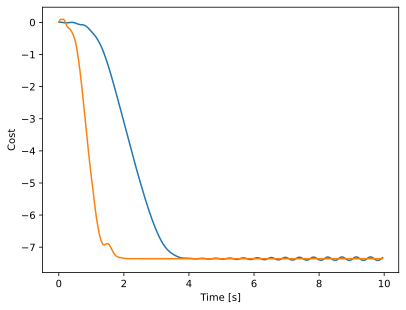

In [13]:
steps = 199
dt = 0.05
time = np.linspace(0,steps*dt, num=steps)

# plt.style.use("ggplot")

for i, J in enumerate(J_sim_results):
  plt.plot(time, J, label='N={:.1f}s'.format(N_values[i]))
# plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Cost")

tikzplotlib.save("results/plots/cost_for_different_horizon_lengths.tex")

u_lim = 8

In [8]:
# N_values = [0.1, 0.2, 1.0, 1.8, 2.1]

# x_sim_results = []
# u_sim_results = []
# J_sim_results = []

# for i, N in enumerate(N_values):
#   print('Calculating for N={:.2f}s'.format(N))
#   x_sim, u_sim, J_sim = simulate(sim=sim,steps=200, N=N, u_lim=8)
  
#   x_sim_results.append(x_sim)
#   u_sim_results.append(u_sim)
#   J_sim_results.append(J_sim)

In [9]:
# for i, J in enumerate(J_sim_results):
#   plt.plot(J, label='N={:.2f}s'.format(N_values[i]))
# plt.legend()
# plt.show()

### Animate and save

In [10]:
plotter = Plotter

for i, x_sim in enumerate(x_sim_results):
  anim = plotter.animate_pendulum(x_sim[:,0], x_sim[:,1], model_params_sim.L1, model_params_sim.L2, dt=0.05)
  f = r"results/animations/animation-N-{}.gif".format(int(N_values[i]*10))
  anim.save(f, writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.


## Model Mismatch Analysis

In [11]:
# mismatch_values = [0.0001, 0.001, 0.01, 0.1]

# x_sim_mismatched_results = []
# u_sim_mismatched_results = []
# J_sim_mismatched_results = []

# for i, mismatch in enumerate(mismatch_values):
#   print('Calculating for mismatch={:f}'.format(mismatch))

#   m1 = 0.5 + mismatch
#   m2 = 0.5 - mismatch
#   L1 = 0.5 + mismatch
#   L2 = 0.5 - mismatch
#   l2 = 0.5*L2
#   l1 = 0.5*L1
#   I1 = m1*l1**2
#   I2 = m2*l2**2
#   f1 = 0.1
#   f2 = 0.1
  
#   model_params_mismatched = ModelParameters

#   model_params_mismatched.m1 = m1
#   model_params_mismatched.m2 = m2
#   model_params_mismatched.L1 = L1
#   model_params_mismatched.L2 = L2
#   model_params_mismatched.l1 = l2
#   model_params_mismatched.l2 = l1
#   model_params_mismatched.I1 = I1
#   model_params_mismatched.I2 = I2
#   model_params_mismatched.f1 = f1
#   model_params_mismatched.f2 = f2

#   sim_mismatch = Simulator(dt=0.05)
#   sim_mismatch.set_model_params(model_parameters=model_params_mismatched)

#   x_sim, u_sim, J_sim = simulate(sim=sim_mismatch, N=1.0)

#   x_sim_results.append(x_sim)
#   u_sim_results.append(u_sim)
#   J_sim_results.append(J_sim)

Calculating for mismatch=0.000100


100%|██████████| 299/299 [00:33<00:00,  9.02it/s]


Calculating for mismatch=0.001000


 26%|██▌       | 78/299 [00:08<00:25,  8.83it/s]


KeyboardInterrupt: 

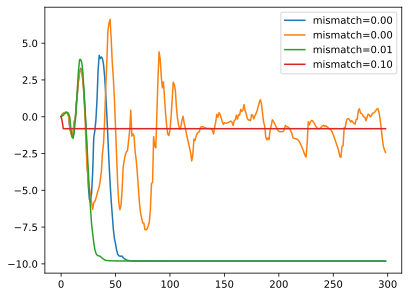

In [ ]:
# for i, J in enumerate(J_sim_results[-4:]):
#   plt.plot(J, label='mismatch={:.2f}s'.format(mismatch_values[i]))
# plt.legend()
# plt.show()

# Plot

In [ ]:
x_sim=x_sim_results[-1]
print(model_params_mismatched.L1)
plotter = Plotter
anim = plotter.animate_pendulum(x_sim[:,0], x_sim[:,1], 0.6, 0.4, dt=0.05)
anim

0.5


In [ ]:
plotter = Plotter
anim = plotter.animate_pendulum(x_sim[][:,2], x_sim[:,2], model_params_sim.L1, model_params_sim.L2, dt=0.05)
anim

In [ ]:
# f = r"results/animations/animation.gif" 

# anim.save(f, writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.
